# Imports

In [1]:
import tensorflow as tf        
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import os
import datetime
import pickle

2023-02-22 21:49:58.373348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 21:50:00.600585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/include:/usr/local/cuda-11.8/lib64:
2023-02-22 21:50:00.600754: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.8/include:/usr/local/cuda-11.8/lib64:
2023-02-22 21:50

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-02-22 21:50:02.969862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 21:50:04.352698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1608 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 750 Ti, pci bus id: 0000:02:00.0, compute capability: 5.0


# Data

In [3]:
DATA_PATH = "./data/"
BATCH_SIZE = 4
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
SEED = 123
N_CLASSES = 66

def getDataset(path):
    return tf.keras.utils.image_dataset_from_directory(
                path,
                labels=None,
                color_mode='rgb',
                batch_size=BATCH_SIZE,
                image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                shuffle=True,
                seed=SEED,
                validation_split=None,
                interpolation='bilinear',
                crop_to_aspect_ratio=True,
            )

In [4]:
train_x = getDataset(DATA_PATH + "training/images")
train_y = getDataset(DATA_PATH + "training/instances")

Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.


In [5]:
test_x = getDataset(DATA_PATH + "validation/images")
test_y = getDataset(DATA_PATH + "validation/instances")

Found 200 files belonging to 1 classes.
Found 200 files belonging to 1 classes.


In [6]:
train_ds = tf.data.Dataset.zip((train_x, train_y))
test_ds = tf.data.Dataset.zip((test_x, test_y))

In [7]:
def displayExample(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

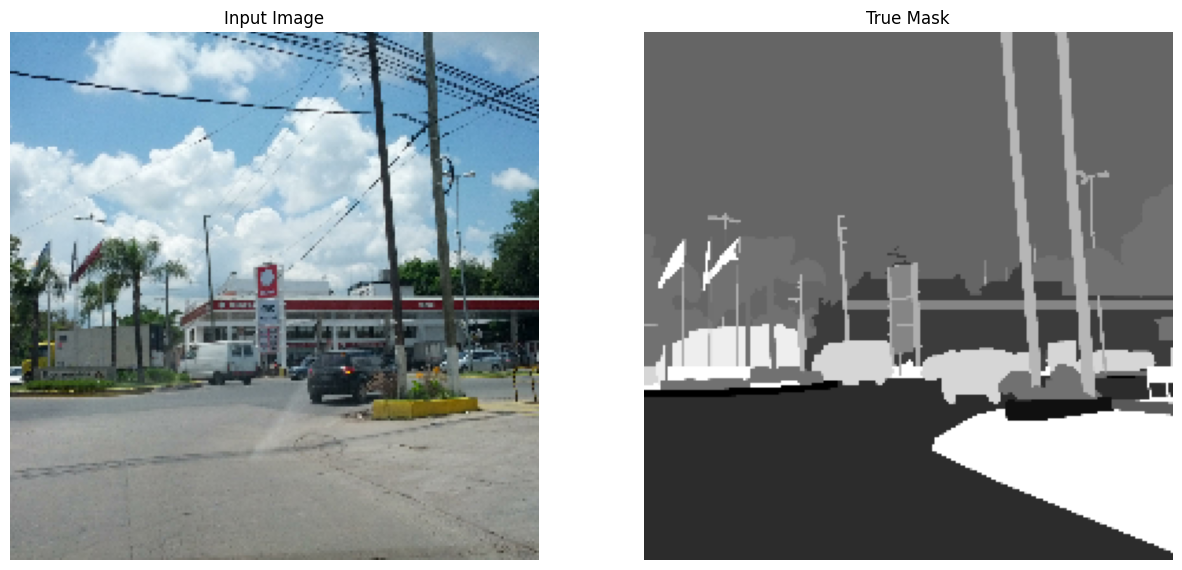

In [8]:
for images, masks in train_ds.take(1):
    sample_image, sample_mask = images[0], masks[0]
    displayExample([sample_image, sample_mask])

In [9]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0 # [0.0, 1.0]
    input_mask = tf.cast(input_mask[:, :, :, 0], np.uint8) # [0, 65]
    input_mask = tf.one_hot(input_mask, N_CLASSES) # One hot each pixel
    return input_image, input_mask

In [10]:
train_ds = train_ds.map(normalize)
test_ds = test_ds.map(normalize)

# Model

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [12]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [13]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding='same')  # 128x128 -> 256x256

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [14]:
model = unet_model(output_channels=N_CLASSES)

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy', tf.keras.metrics.Precision()])

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 112, 112, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 56, 56, 144                                               
                                ),                                                                
                                 (None, 28, 28, 192                                         

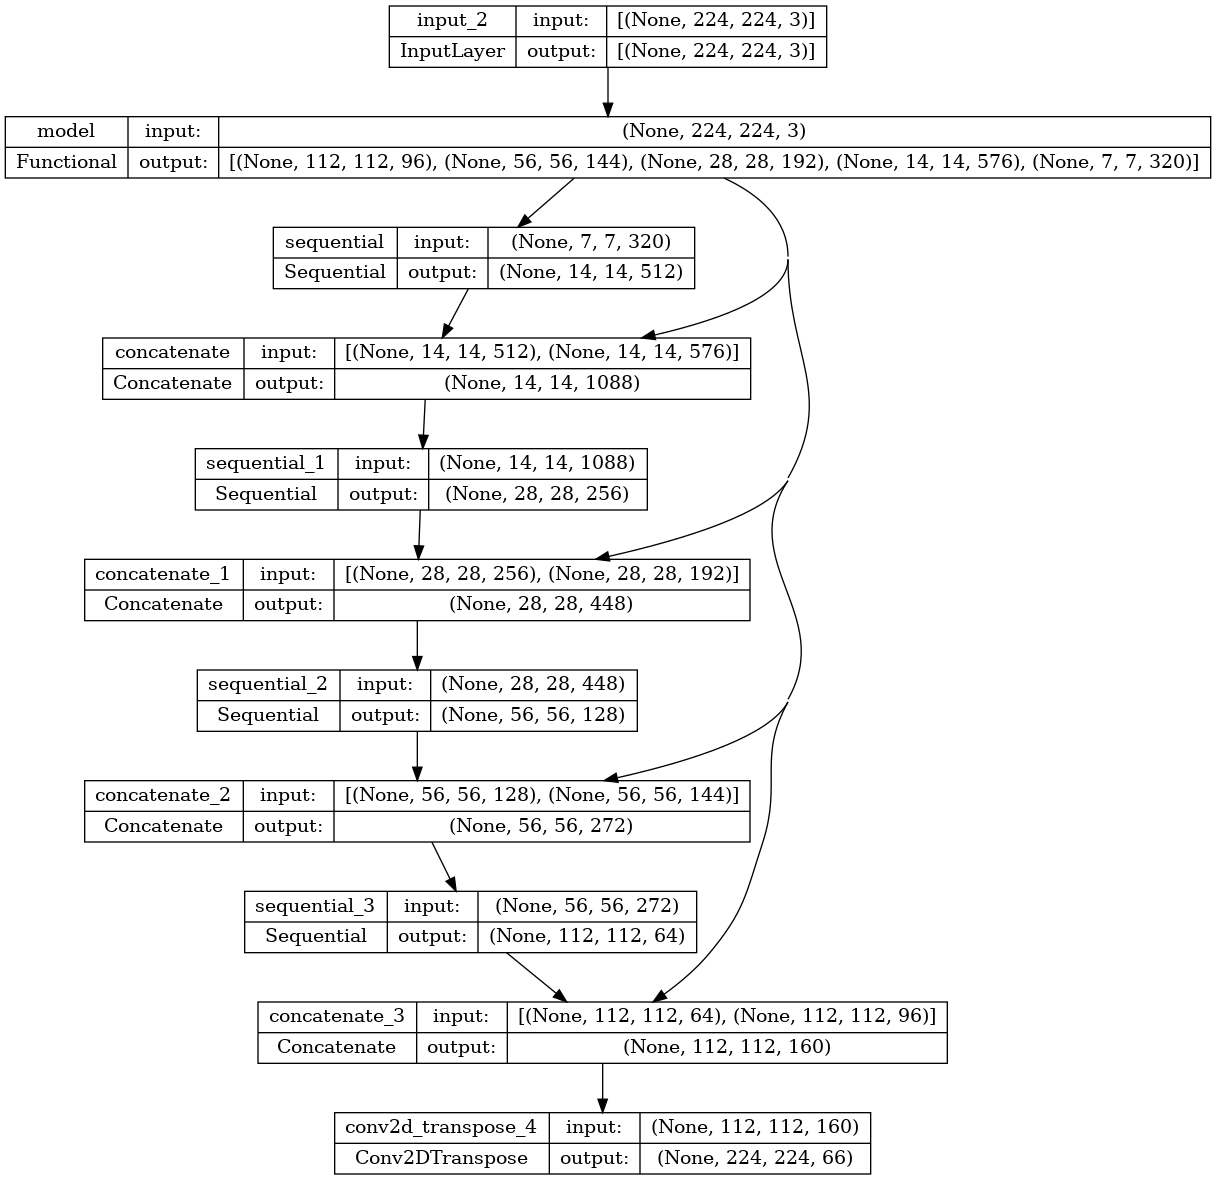

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    if len(pred_mask.shape) > 3:
        pred_mask = pred_mask[0]
    return pred_mask

In [18]:
def show_predictions(dataset=None, num=1):
    for image, mask in dataset.take(num):
        pred_mask = create_mask(model.predict(image))
        true_mask = create_mask(mask[0])
        displayExample([image[0], true_mask, pred_mask])

2023-02-22 21:50:16.401163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-22 21:50:18.440024: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-02-22 21:50:19.135132: W tensorflow/tsl/framework/bfc_allocator.cc:360] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-

1/1 [==============================] - 6s 6s/step


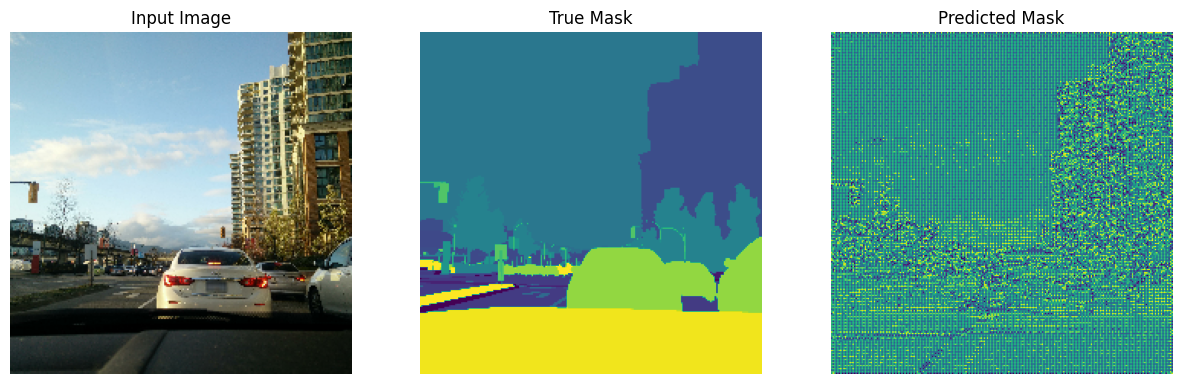

In [19]:
show_predictions(train_ds)

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(train_ds)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [21]:
checkpoint_filepath = './models/model.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    verbose=1,
    mode='max',
    save_freq="epoch",
    save_best_only=True)

In [22]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

## Training

1/1 [==============================] - 0s 38ms/step


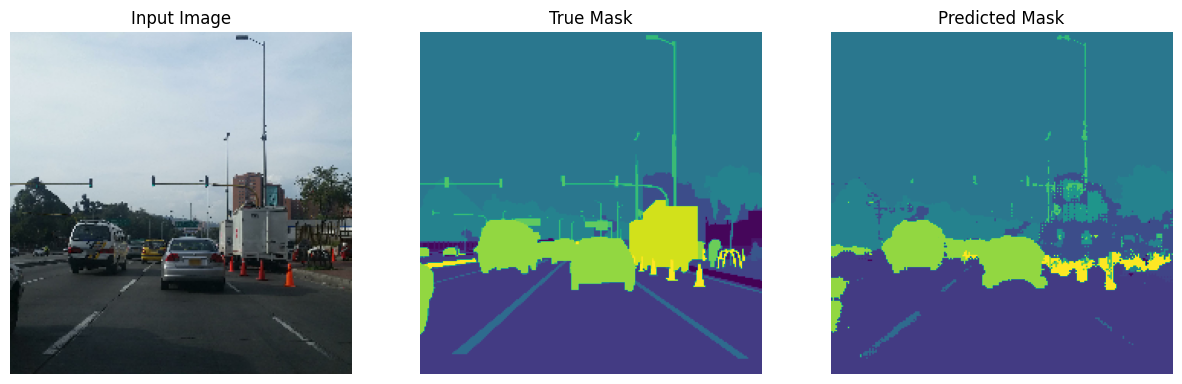


Sample Prediction after epoch 16


Epoch 16: val_loss did not improve from 1.01767
200/200 [==============================] - 87s 421ms/step - loss: 0.6176 - categorical_accuracy: 0.8319 - precision: 0.3483 - val_loss: 0.8278 - val_categorical_accuracy: 0.7940 - val_precision: 0.3590
Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......concatenate_1
.........vars
......concatenate_2
.........vars
......concatenate_3
.........vars
......conv2d_transpose
.........vars
............0
............1
......functional
.........layers
............add
...............vars
............add_1
...............vars
............add_2
...............vars
............add_3
...............vars
............add_4
...............vars
............add_5
...............vars
............add_6
...............vars
............add_7
...............vars
............add_8
...............vars
............add_9
...............vars
............batch_normalizat

In [23]:
EPOCHS = 100
STEPS_PER_EPOCH = 800 // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 200//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_ds, 
                          epochs = EPOCHS, 
                          steps_per_epoch = STEPS_PER_EPOCH,
                          validation_steps = VALIDATION_STEPS, 
                          validation_data = test_ds,
                          callbacks = [DisplayCallback(), model_checkpoint_callback, early_stopping_callback])

with open('./histories/history.pickle', 'wb+') as file:
    pickle.dump(model_history, file)

In [24]:
def displayLearningCurves(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss curves')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()
    
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('Accuracy curves')
    plt.ylabel('Acc')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

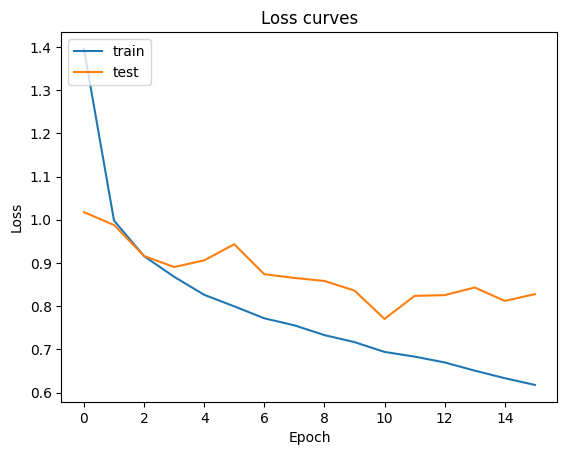

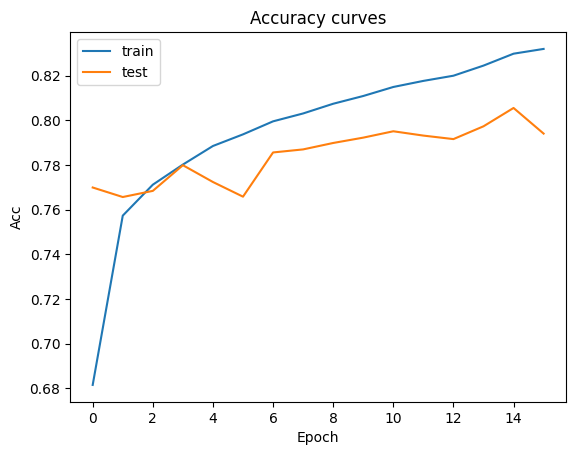

In [25]:
displayLearningCurves(model_history)